# OBJECTIVE:
# Build a predictive model to estimate the status of a loan after 360 days

For the purposes of this excercise we will use a sample size of "MOCK-UP DATA".

Stages:
    1. Install libraries and Packages 
    2. Import + explore dataset
    3. Pre-processing the data
    4. Feature selection
    5. Building ML Classification Model 
    6. Test accuracy of Model
    7. Improve + Iterate


# 1. Install Libraries

In [1]:
# importing necessary libraries for analysis, building models and visualization.
%matplotlib inline

import pandas as pd
import numpy as np
import random

from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier

C:\Users\Krupa Suchak\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 2. Importing + Exploring Dataset

In [2]:
# importing a random sample of 1000 rows 
# converting an excel file to a pandas dataframe for analysis.
random.seed(1)
filename = 'SyntheticData.xls'
n = 9195 - 1 #number of records in file (excludes header)
s = 1000 #desired sample size
skip = sorted(random.sample(xrange(1,n),n-s))

df = pd.read_excel(filename, header=0, skiprows=skip)

## First order of business - drop duplicates

In [3]:
df.drop_duplicates(inplace=True)

Clean file so no duplicates!

In [4]:
# checking the size of our dataframe - 15 columns and 9195 rows
df.shape

(1001, 13)

In [5]:
# checking the columns and datatype available in our dataframe df.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1001 entries, 0 to 1000
Data columns (total 13 columns):
Product           1001 non-null object
CustomerGender    1001 non-null object
Location          1001 non-null object
Region            1001 non-null object
TotalPrice        1001 non-null int64
StartDate         1001 non-null object
Deposit           1001 non-null int64
DailyRate         1001 non-null int64
TotalDays         1001 non-null int64
AmountPaid30      1001 non-null int64
AmountPaid60      1001 non-null int64
AmountPaid360     1001 non-null int64
LoanStatus360     1001 non-null object
dtypes: int64(7), object(6)
memory usage: 109.5+ KB


In [6]:
# Snippet of data observed in the dataframe 
df[1:2]

,Product,CustomerGender,Location,Region,TotalPrice,StartDate,Deposit,DailyRate,TotalDays,AmountPaid30,AmountPaid60,AmountPaid360,LoanStatus360
1,Product B,Female,Location 26,Region 3,16600,6/6/2014,2000,40,365,3401,4201,15381,Active


Great, our vector contains a lot of numerical datapoints and a number of continuous or categorical objects. We shall asses them seperately and find ways to extract the jist of the given information. By this I mean we will find ways to quantify the non-numeric datapoints so that it can be used as inputs to any of selected machine learning model. This is ever so important for the mere fact that ML models only accept numeric values as inputs.

Right off the bat we can say that 'StartDate' becomes continuous using the time step delta which would then require time series analysis. For the purposes of this project, we will stick to standard classification models.

For the rest of the features lets identify their corresponding number of categories.

### Categorical Features

In [7]:
# function to identify unique categories of columns with 'object' datatype.
for col_name in df.columns:
    if df[col_name].dtypes == 'object':
        unique_cat = len(df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} unique categories".format(col_name=col_name, unique_cat=unique_cat))

Feature 'Product' has 6 unique categories
Feature 'CustomerGender' has 3 unique categories
Feature 'Location' has 259 unique categories
Feature 'Region' has 18 unique categories
Feature 'StartDate' has 709 unique categories
Feature 'LoanStatus360' has 3 unique categories


'LoanStatus360' is our target, y feature we are trying to predict.

'StartDate' even if considered has way too many categories to create features from individual columns.

'Region' and 'Location' also have numerous categories in order to be able to extract meaningful signal from each.

For 'CustomerGender' and 'Product' we need to take a deeper dive to under each category and number of vectors associated with each.

In [8]:
# Type of products sold and its corresponding sales figure.
df['Location'].groupby(df.Product).count()

Product
Product A    339
Product B    434
Product C    106
Product D    102
Product E     19
Product F      1
Name: Location, dtype: int64

Looks like Product A and B are most commonly sold. And, Product F has the least, with a scare 5 item sales.

In [9]:
# Sales figure based on the gender of buyer.
df['Product'].groupby(df.CustomerGender).count()

CustomerGender
Female          366
Male            573
NotSpecified     62
Name: Product, dtype: int64

Females loan out 36.6% of the products, Males 57.2% and about 6.2% of the products are sold to unspecified individuals.

'Product' and 'CustomerGender' seem relevant features and we shall create features for each unique category in the pre-processing stage.

### Moving on to numberical features...

In [10]:
# let's take a deeper dive into the range and extend of the numerical columns in df
df.describe()

,TotalPrice,Deposit,DailyRate,TotalDays,AmountPaid30,AmountPaid60,AmountPaid360
count,1001.000000,1001.000000,1001.000000,1001.0,1001.000000,1001.000000,1001.000000
mean,19100.674326,2278.221778,46.088911,365.0,3521.150849,4662.173826,14528.547453
std,5706.261379,1341.553292,12.643698,0.0,2339.447008,2581.657373,6337.719556
min,13775.000000,1000.000000,35.000000,365.0,-2510.000000,-2310.000000,-2000.000000
25%,16600.000000,2000.000000,40.000000,365.0,2490.000000,3400.000000,11071.000000
50%,16600.000000,2000.000000,40.000000,365.0,3400.000000,4380.000000,15230.000000
75%,20250.000000,2000.000000,50.000000,365.0,4601.000000,5551.000000,16600.000000
max,69225.000000,9000.000000,165.000000,365.0,14002.000000,23001.000000,69225.000000


The min to max gives us an idea on the breath of our dataset, while the mean and std on the distribution. 

At max, it shows there are loans taken that are completed by 360 days.

At min, it shows there are products given on loans have turned into bad debts.

__A key take-away is that on average 23.9% of the loans are not paid back by completion of 360 days.__

Let's take a deeper look into the unique category of each of the numerical features.

In [11]:
df.Deposit.unique()

array([2000, 4000, 1000, 2500, 9000], dtype=int64)

In [12]:
df['Product'].groupby(df.Deposit).count().sort_values(ascending=True)

Deposit
9000     20
2500     21
4000    170
1000    212
2000    578
Name: Product, dtype: int64

By far, the most common deposit amount is TZS 2000.

In [13]:
df.DailyRate.unique()

array([ 40,  50, 125,  35, 165], dtype=int64)

In [14]:
df['Product'].groupby(df.DailyRate).count().sort_values(ascending=True)

DailyRate
165      1
35       7
125     19
50     439
40     535
Name: Product, dtype: int64

Most common daily rate is TZS 40, shortly followed by TZS 50. 

In [15]:
df.TotalPrice.unique()

array([16600, 22250, 20250, 19250, 20750, 15600, 54625, 13775, 69225], dtype=int64)

In [16]:
df['Product'].groupby(df.TotalPrice).count().sort_values(ascending=True)

TotalPrice
69225      1
13775      7
54625     19
20750     21
15600     99
19250    106
20250    142
22250    170
16600    436
Name: Product, dtype: int64

This shows that the most demanded product goes for TZS 16,600.

### Are product and price related?

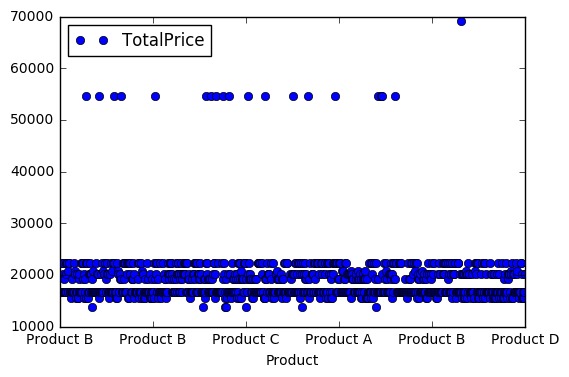

In [17]:
df.plot(x='Product', y='TotalPrice', style='o')

Nope, doesn't look like. But worth a shot to understand out data better.

### Looking into bad debts

In [18]:
# identifying loans taken on products by day 30 of sale.
df[df.AmountPaid30<0].count()

Product           47
CustomerGender    47
Location          47
Region            47
TotalPrice        47
StartDate         47
Deposit           47
DailyRate         47
TotalDays         47
AmountPaid30      47
AmountPaid60      47
AmountPaid360     47
LoanStatus360     47
dtype: int64

In [19]:
# how many loans taken on other products besides A? 
df[(df.AmountPaid30<=0) & (df.Product!='Product A')]

,Product,CustomerGender,Location,Region,TotalPrice,StartDate,Deposit,DailyRate,TotalDays,AmountPaid30,AmountPaid60,AmountPaid360,LoanStatus360


There were 47 loans taken on product sales by day 30. All on product A.

In [20]:
# identifying loans taken on products by day 60 of sale.
df[df.AmountPaid60<0].count()

Product           39
CustomerGender    39
Location          39
Region            39
TotalPrice        39
StartDate         39
Deposit           39
DailyRate         39
TotalDays         39
AmountPaid30      39
AmountPaid60      39
AmountPaid360     39
LoanStatus360     39
dtype: int64

In [21]:
# how many loans taken on other products besides A? 
df[(df.AmountPaid60<=0) & (df.Product!='Product A')]

,Product,CustomerGender,Location,Region,TotalPrice,StartDate,Deposit,DailyRate,TotalDays,AmountPaid30,AmountPaid60,AmountPaid360,LoanStatus360


There were 39 loans taken on product sales by day 30. All on product A.

## Exploring Finished Payments VS Unfinished on Gender Stereotypes

In [22]:
# Slicing out dataframe for finished loans
dff = df[df.LoanStatus360 == 'Finished Payment']

In [23]:
dff.shape

(177, 13)

In [24]:
# Off the unfinished loans whats the effect of gender?
dff['Product'].groupby(dff.CustomerGender).count()

CustomerGender
Female           49
Male            110
NotSpecified     18
Name: Product, dtype: int64

For finished loans, __27.6%__ were females, __62.1%__ males, and __10%__ unspecified.

In [25]:
# Slicing out dataframe for unfinished loans
dfq = df[df.LoanStatus360 != 'Finished Payment']

In [26]:
# Off the unfinished loans whats the effect of gender?
dfq['Product'].groupby(dfq.CustomerGender).count()

CustomerGender
Female          317
Male            463
NotSpecified     44
Name: Product, dtype: int64

In [27]:
dfq.shape

(824, 13)

For unfinished loans, __38.5%__ were females, __56.2%__ males, and __5.3%__ unspecified.

Percentage of males is unaffected by finished or unfinished loans.

Percentage of females increases on unfinished payments while that of unspecified decreases. This might be due to increased information from that particular group of females who reveal with time.

Atleast, one of these features, whether females or unspecified will be an important indicator of loan prediction status.

# 3. Pre-processing Stage

Here we will add columns to see how far off track users of the products are in the plans of repaing loans on the 30th day as well as 60th day. For this we shall add 2 more features.

In [28]:
# Payments off track on day 30
df['OffTrack30']=df['AmountPaid30']-(df['DailyRate']*30+df['Deposit'])
# Payments off track on day 60
df['OffTrack60']=df['AmountPaid60']-(df['DailyRate']*60+df['Deposit'])

In [29]:
df.head()

,Product,CustomerGender,Location,Region,TotalPrice,StartDate,Deposit,DailyRate,TotalDays,AmountPaid30,AmountPaid60,AmountPaid360,LoanStatus360,OffTrack30,OffTrack60
0,Product B,Female,Location 15,Region 2,16600,5/1/2014,2000,40,365,3160,4480,16380,Active,-40,80
1,Product B,Female,Location 26,Region 3,16600,6/6/2014,2000,40,365,3401,4201,15381,Active,201,-199
2,Product B,Male,Location 29,Region 1,16600,3/27/2015,2000,40,365,3128,4281,15781,Active,-72,-119
3,Product B,Male,Location 50,Region 1,16600,3/24/2014,2000,40,365,2920,4200,15400,Active,-280,-200
4,Product B,Male,Location 26,Region 3,16600,2/22/2015,2000,40,365,3041,3561,9081,Active,-159,-839


Now, dropping off categorical feature with high categories and creating columns for each of the other categories.

In [30]:
data = df.drop(['Location','Region','StartDate'], axis=1)

In [31]:
data[1:2]

,Product,CustomerGender,TotalPrice,Deposit,DailyRate,TotalDays,AmountPaid30,AmountPaid60,AmountPaid360,LoanStatus360,OffTrack30,OffTrack60
1,Product B,Female,16600,2000,40,365,3401,4201,15381,Active,201,-199



## .. this way or use One-Hot Encoding

In [32]:
todummy_list = ['Product', 'CustomerGender']

def dummy_df(data, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(data[x], prefix=x, dummy_na=False)
        data = data.drop(x, 1)
        data = pd.concat([data, dummies], axis=1)
    return data

X = dummy_df(data,todummy_list)
X.head()

,TotalPrice,Deposit,DailyRate,TotalDays,AmountPaid30,AmountPaid60,AmountPaid360,LoanStatus360,OffTrack30,OffTrack60,Product_Product A,Product_Product B,Product_Product C,Product_Product D,Product_Product E,Product_Product F,CustomerGender_Female,CustomerGender_Male,CustomerGender_NotSpecified
0,16600,2000,40,365,3160,4480,16380,Active,-40,80,0,1,0,0,0,0,1,0,0
1,16600,2000,40,365,3401,4201,15381,Active,201,-199,0,1,0,0,0,0,1,0,0
2,16600,2000,40,365,3128,4281,15781,Active,-72,-119,0,1,0,0,0,0,0,1,0
3,16600,2000,40,365,2920,4200,15400,Active,-280,-200,0,1,0,0,0,0,0,1,0
4,16600,2000,40,365,3041,3561,9081,Active,-159,-839,0,1,0,0,0,0,0,1,0


## Crucial to fill null values before injecting it into our ML model.

In [33]:
X.fillna('0');

In [34]:
X.shape

(1001, 19)

Now we have 19 features to work with.

How do these feature correlate? Can we drop of some more if they are highly correlated?

In [35]:
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm')

C:\Users\Krupa Suchak\Anaconda2\lib\site-packages\matplotlib\colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


# 4. Feature Selection

In [36]:
y1= X[['LoanStatus360']]
X= X.drop(['AmountPaid360','LoanStatus360'], axis=1)

In [37]:
select = SelectKBest(k=10)
selected_features = select.fit(X, y1)
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [X.columns[i] for i in indices_selected]

X_selected = X[colnames_selected];

C:\Users\Krupa Suchak\Anaconda2\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Krupa Suchak\Anaconda2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [3] are constant.
  UserWarning)
C:\Users\Krupa Suchak\Anaconda2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [38]:
print(colnames_selected)

[u'TotalPrice', u'DailyRate', u'AmountPaid30', u'AmountPaid60', 'OffTrack30', 'OffTrack60', u'Product_Product A', u'Product_Product C', u'Product_Product D', u'CustomerGender_Female']


Above are the least number of features selected to capture the best signal for predictive purposes.

# 5+6. Applying Classification Models and Accuracy Testing

Splitting 70% data into train set and 30% into test set.

## Train includes Features and Test includes the Label

In [39]:
random.seed(0) # very important to get reproducible data
X_train, X_test2, y_train, y_test2 = train_test_split(X_selected, y1, test_size=0.3, random_state=42)

Checking the total number of rows and columns in each train and test set.

In [40]:
X_train.shape

(700, 10)

In [41]:
X_test2.shape

(301, 10)

Here's applying the predictive model optimize accuracy of classification captured by accuracy_score below.

Using Decision Tree Classifier

In [42]:
clf1 = tree.DecisionTreeClassifier()
clf1 = clf1.fit(X_train, y_train)
pred1 = clf1.predict(X_test2)
acc1 = accuracy_score(pred1, y_test2)
acc1

0.72093023255813948

Using Gradient Boosting Classifier

In [43]:
clf2 = GradientBoostingClassifier()
clf2 = clf1.fit(X_train, y_train)
pred2 = clf1.predict(X_test2)
acc2 = accuracy_score(pred2, y_test2)
acc2

0.70764119601328901

The best accuracy we determined was __73.4%__ through Decision Trees methods for the selected features from the given dataset.

# 5. Improvement

Going forward, it would be beneficial to capture signal better by way of collecting more information on the transaction and buyer of our products such as: age, education status (completed primary school, secondar school, high school, college, univeristy, postdoctorate), occupation, salary, industry. 

With more time, I would code a program with inbuilt classifier to test accuracy on more than the two used above. 

Summary:
    1. Install libraries and Packages 
        - install packages in terminal
        - for good programming practice install libraries at top
        - do not forget %matplot inline for visualization
    2. Import + explore dataset
        - when importing point towards path of data 
        - remove duplicates
        - identify datatype; explore numerical and categorical datasets seperately
    3. Pre-processing the data
        - add/remove features (PCA)
        - fill null values
        - convert to all numerical features
    4. Feature selection
        - less is better to avoid overfitting
        - too few may not provide suffient signal 
    5. Building ML Classification Model 
        - split data into test:train :: 30:70 or test:validate:train :: 20:20:60
    6. Test accuracy of Model
    7. Improve + Iterate